<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Soft_Computing_Assignment_Fuzzy_Logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U ucimlrepo
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=4e3468fa17d5754dc508bb8f5370d0bac0c5a9749491427ea27c29894be27d72
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

# **Data Exploration**

In [ ]:
print("Number of columns : ", X.shape[1])
print("Number of rows    : ", X.shape[0])

Number of columns :  127
Number of rows    :  1994


In [ ]:
X.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?


In [ ]:
for index,col in enumerate(X.columns):
  print("Column : ",index)
  print(col , " : ", X[col].info())
  print("Missing value : ",np.sum(X[col] == '?'))
  print(X[col].unique())
  print("\n\n")

Column :  0
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: state
Non-Null Count  Dtype
--------------  -----
1994 non-null   int64
dtypes: int64(1)
memory usage: 15.7 KB
state  :  None
Missing value :  0
[ 8 53 24 34 42  6 44 21 29 36 25 55 19 18 12 41 39 54  9  1 51 40 35 33
 48  4 37 49 46 28 22 45 16 47  5 50 13 23 38 27 20 56  2 11 32 10]



Column :  1
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: county
Non-Null Count  Dtype 
--------------  ----- 
1994 non-null   object
dtypes: object(1)
memory usage: 15.7+ KB
county  :  None
Missing value :  1174
['?' '5' '95' '7' '21' '87' '187' '1' '27' '129' '31' '193' '29' '680'
 '23' '3' '19' '35' '790' '53' '9' '119' '99' '17' '11' '135' '133' '45'
 '39' '61' '43' '157' '15' '13' '37' '107' '89' '41' '93' '71' '590' '55'
 '101' '75' '57' '63' '760' '69' '25' '830' '77' '155' '151' '123' '113'
 '49' '139' '169' '630' '79' '510' '65' '81' '105' '141' '33' '59' '131

In [ ]:
index_of_col_with_missing_value = []

for index,col in enumerate(X.columns):
  if X[col].astype(str).str.contains("\?").any():
    print("Column name  : ",col)
    print("Column type  : ",type(X[col]))
    print("Column index : ",index)
    print("Number of missing value : ", np.sum(X[col] == "?"))
    index_of_col_with_missing_value.append(index)
    print("\n")

print("Total number of col with missing value : ", len(index_of_col_with_missing_value))
print(index_of_col_with_missing_value)

Column name  :  county
Column type  :  <class 'pandas.core.series.Series'>
Column index :  1
Number of missing value :  1174


Column name  :  community
Column type  :  <class 'pandas.core.series.Series'>
Column index :  2
Number of missing value :  1177


Column name  :  OtherPerCap
Column type  :  <class 'pandas.core.series.Series'>
Column index :  30
Number of missing value :  1


Column name  :  LemasSwornFT
Column type  :  <class 'pandas.core.series.Series'>
Column index :  101
Number of missing value :  1675


Column name  :  LemasSwFTPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  102
Number of missing value :  1675


Column name  :  LemasSwFTFieldOps
Column type  :  <class 'pandas.core.series.Series'>
Column index :  103
Number of missing value :  1675


Column name  :  LemasSwFTFieldPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  104
Number of missing value :  1675


Column name  :  LemasTotalReq
Column type  :  <class 'pan

In [ ]:
#Convert data into dataframe
feature = pd.DataFrame(X,columns = communities_and_crime.data.features_name)
target = pd.DataFrame(y,columns = communities_and_crime.data.targets_name)

# **Data Cleaning and Preprocessing**

In [ ]:
#Drop col with missing value
col_to_drop = []
col_to_remain = []

for index in index_of_col_with_missing_value:
  col = feature.columns[index]
  if np.sum(feature[col]=="?") > 1000:
    col_to_drop.append(col)
  else:
    col_to_remain.append(col)

print("Column's names to drop   : ", col_to_drop)
print("Column's names to remain : ", col_to_remain)

#Drop the columns
feature.drop(columns = col_to_drop ,axis = 1,inplace = True)

#Replace the "?" value with median value
feature[col_to_remain] = feature[col_to_remain].replace("?",np.nan).astype(float)
feature.loc[:, col_to_remain] = feature[col_to_remain].fillna(feature[col_to_remain].median())

check_null = feature.isnull().sum() > 0
columns_with_null = check_null[check_null].index.tolist()
print("Columns with missing value : ",columns_with_null)

Column's names to drop   :  ['county', 'community', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']
Column's names to remain :  ['OtherPerCap']
Columns with missing value :  []


In [ ]:
feature = feature.apply(pd.to_numeric,errors='ignore')


#Check Column with 'Object' Data Type
col_with_obj_datatype = []
for index,col in enumerate(feature.columns):
  if str(feature[col].dtype) != 'float64' and  str(feature[col].dtype) != 'int':
    print("Column name  : ",col)
    print("Column index : ",index)
    col_with_obj_datatype.append(col)
    print("\n")

feature.drop(columns = col_with_obj_datatype,inplace = True)

Column name  :  state
Column index :  0


Column name  :  communityname
Column index :  1


Column name  :  fold
Column index :  2




In [ ]:
#Split the data into train,test and validaton set
from sklearn.model_selection import train_test_split

test_size = 0.3

X_train,X_temp,y_train,y_temp = train_test_split(feature,target,test_size = test_size,random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size = 0.5,random_state = 42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (1395, 100) (1395, 1)
Testing data shape: (299, 100) (299, 1)
Validation data shape: (300, 100) (300, 1)


# **Feature Selection - GA Algorithm & Correlation**

In [ ]:
import random
import statistics
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [ ]:
def filter_low_correlation_features_with_target(df,threshold,target):
  col_low_corr = []
  corr_matrix = df.corrwith(df[target])
  for i in df.columns:
    if abs(corr_matrix[i]) < threshold:
      col_low_corr.append(i)

  df.drop(columns = col_low_corr,axis = 1,inplace = True)
  print("Features with low correlation with target that has been dropped : ",col_low_corr)


In [ ]:
def filter_high_correlation_features_with_target(df,target,threshold):
  col_corr = set()
  corr_matrix = df.corr()
  for i in range(len(df.columns)):
    for j in range (i):
      if corr_matrix.iloc[i,j] > threshold:
        col_name1 = corr_matrix.columns[j]
        col_name2 = corr_matrix.columns[i]
        corr_name1_target = abs(corr_matrix.loc[col_name1,target].iloc[0])
        corr_name2_target = abs(corr_matrix.loc[col_name2,target].iloc[0])
        if corr_name1_target > corr_name2_target:
           col_corr.add(col_name2)
        else:
           col_corr.add(col_name1)

  df.drop(columns = col_corr,axis = 1,inplace = True)
  print("Feature with high correlation with target that has been dropped : ",col_corr)
  return col_corr

In [ ]:
def genetic_algo(data,features,target,population_size,tol_level,top_number):

  def init_population(population_size,c,top_number):

    population = []
    for i in range(population_size):
      individual = [0]*c
      j = 0
      while(j<top_number):
        p = random.uniform(0,1)
        position = random.randrange(c)
        if(p>=0.5 and individual[position]==0):
          individual[position]=1
          j=j+1

      #edge case if all genes are 0 then we will make any one gene as 1
      if(sum(individual)==0):
        position = random.randrange(c)
        individual[position] = 1

      population.append(individual)

    return population




  def calculate_fitness(features,target):

    model = xgb.XGBRegressor()
    scores = cross_val_score(model, features, target, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()



  def get_fitness(population,data):

    fitness_values = []
    for individual in population:
      df = data
      i=0
      for column in data:
        if(individual[i]==0):
          df = df.drop(column,axis=1)
        i=i+1

      features = df
      individual_fitness = calculate_fitness(features,target)
      fitness_values.append(individual_fitness)

    return fitness_values



  def select_parents(population,fitness_values):

    parents = []
    total = sum(fitness_values)
    norm_fitness_values = [x/total for x in fitness_values]

    #find cumulative fitness values for roulette wheel selection
    cumulative_fitness = []
    start = 0
    for norm_value in norm_fitness_values:
      start+=norm_value
      cumulative_fitness.append(start)

    population_size = len(population)
    for count in range(population_size):
      random_number = random.uniform(0, 1)
      individual_number = 0
      for score in cumulative_fitness:
        if(random_number<=score):
          parents.append(population[individual_number])
          break
        individual_number+=1

    return parents



  #high probability crossover
  def two_point_crossover(parents,probability):

    random.shuffle(parents)
    #count number of pairs for crossover
    no_of_pairs = round(len(parents)*probability/2)
    chromosome_len = len(parents[0])
    crossover_population = []

    for num in range(no_of_pairs):
      length = len(parents)
      parent1_index = random.randrange(length)
      parent2_index = random.randrange(length)
      while(parent1_index == parent2_index):
        parent2_index = random.randrange(length)

      start = random.randrange(chromosome_len)
      end = random.randrange(chromosome_len)
      if(start>end):
        start,end = end, start

      parent1 = parents[parent1_index]
      parent2 = parents[parent2_index]
      child1 =  parent1[0:start]
      child1.extend(parent2[start:end])
      child1.extend(parent1[end:])
      child2 =  parent2[0:start]
      child2.extend(parent1[start:end])
      child2.extend(parent2[end:])
      parents.remove(parent1)
      parents.remove(parent2)
      crossover_population.append(child1)
      crossover_population.append(child2)

    #to append remaining parents which are not undergoing crossover process
    if(len(parents)>0):
      for remaining_parents in parents:
        crossover_population.append(remaining_parents)

    return crossover_population



  #low probability mutation
  #mutation_probability is generally low to avoid a lot of randomness
  def mutation(crossover_population):

    #swapping of zero with one to retain no of features required
    for individual in crossover_population:
      index_1 = random.randrange(len(individual))
      index_2 = random.randrange(len(individual))
      while(index_2==index_1 and individual[index_1] != individual[index_2]):
        index_2 = random.randrange(len(individual))

      #swapping the bits
      temp = individual[index_1]
      individual[index_1] = individual[index_2]
      individual[index_2] = temp

    return crossover_population


  c = data.shape[1] #length of the chromosome
  population= init_population(population_size,c,top_number)
  fitness_values = get_fitness(population,data)
  parents = select_parents(population,fitness_values)
  crossover_population = two_point_crossover(parents,0.78)
  population = crossover_population
  p = random.uniform(0,1)
  if(p<=0.001):
    mutated_population = mutation(crossover_population)
    population = mutated_population
  fitness_values = get_fitness(population,data)
  variance_of_population = statistics.variance(fitness_values)
  print("Variance is : ",variance_of_population)
  gen = 1


  #repeating algorithm til stopping criterion is met
  while(variance_of_population > tol_level):
    print('Generation-',gen)
    parents = select_parents(population,fitness_values)
    crossover_population = two_point_crossover(parents,0.78)
    population = crossover_population
    p = random.uniform(0,1)
    if(p<=0.001): #mutation prob here
      mutated_population = mutation(crossover_population)
      population = mutated_population
    fitness_values = get_fitness(population,data)
    variance_of_population = statistics.variance(fitness_values)
    print("Variance is",variance_of_population)
    gen+=1

  best_features = []
  best_f1_score = 0
  optimal_fitness = sum(fitness_values)/len(fitness_values)
  print('Average fitness is: ',optimal_fitness)
  for index,fitness_value in enumerate(fitness_values):
    error = abs((fitness_value - optimal_fitness)/optimal_fitness)
    if(error <= 0.01):
      best_features = population[index]
      best_f1_score = fitness_value

  return best_features,best_f1_score

In [ ]:
#running the algorithm
df = pd.concat([X_train,y_train],axis = 1)
filter_low_correlation_features_with_target(df,0.3,y_train.columns)
filter_high_correlation_features_with_target(df,y_train.columns,0.85)
top_features, best_score = genetic_algo(df,df[df.columns[:-1]], df[df.columns[-1:]],100,0.05,5)

#printing top features selected through genetic algorithm
i = 0
list_of_features= []
for i in range(len(top_features)):
  if(top_features[i]==1):
    list_of_features.append(X_train.columns[i])

print("Top features:", top_features)
print("List of features:", list_of_features)
print("Best score:", best_score)

Features with low correlation with target that has been dropped :  []
Feature with high correlation with target that has been dropped :  {'PctRecImmig5', 'MedRent', 'RentHighQ', 'PctImmigRecent', 'PctLargHouseOccup', 'MalePctDivorce', 'PctForeignBorn', 'agePct65up', 'PctLess9thGrade', 'perCapInc', 'whitePerCap', 'householdsize', 'PctNotSpeakEnglWell', 'agePct12t21', 'OwnOccLowQuart', 'medIncome', 'PctImmigRec8', 'PersPerFam', 'racePctHisp', 'PctLargHouseFam', 'numbUrban', 'agePct16t24', 'PctYoungKids2Par', 'PctTeen2Par', 'PctHousOwnOcc', 'PctRecImmig8', 'HousVacant', 'PctWorkMomYoungKids', 'OwnOccMedVal', 'PctRecentImmig', 'RentMedian', 'PctImmigRec5', 'TotalPctDiv', 'PctFam2Par', 'NumUnderPov', 'PctBSorMore', 'OwnOccHiQuart', 'pctWWage', 'population', 'PersPerOccupHous'}
Variance is :  0.000106070190240189
Average fitness is:  -0.043167342265119944
Top features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

# **Define rules**

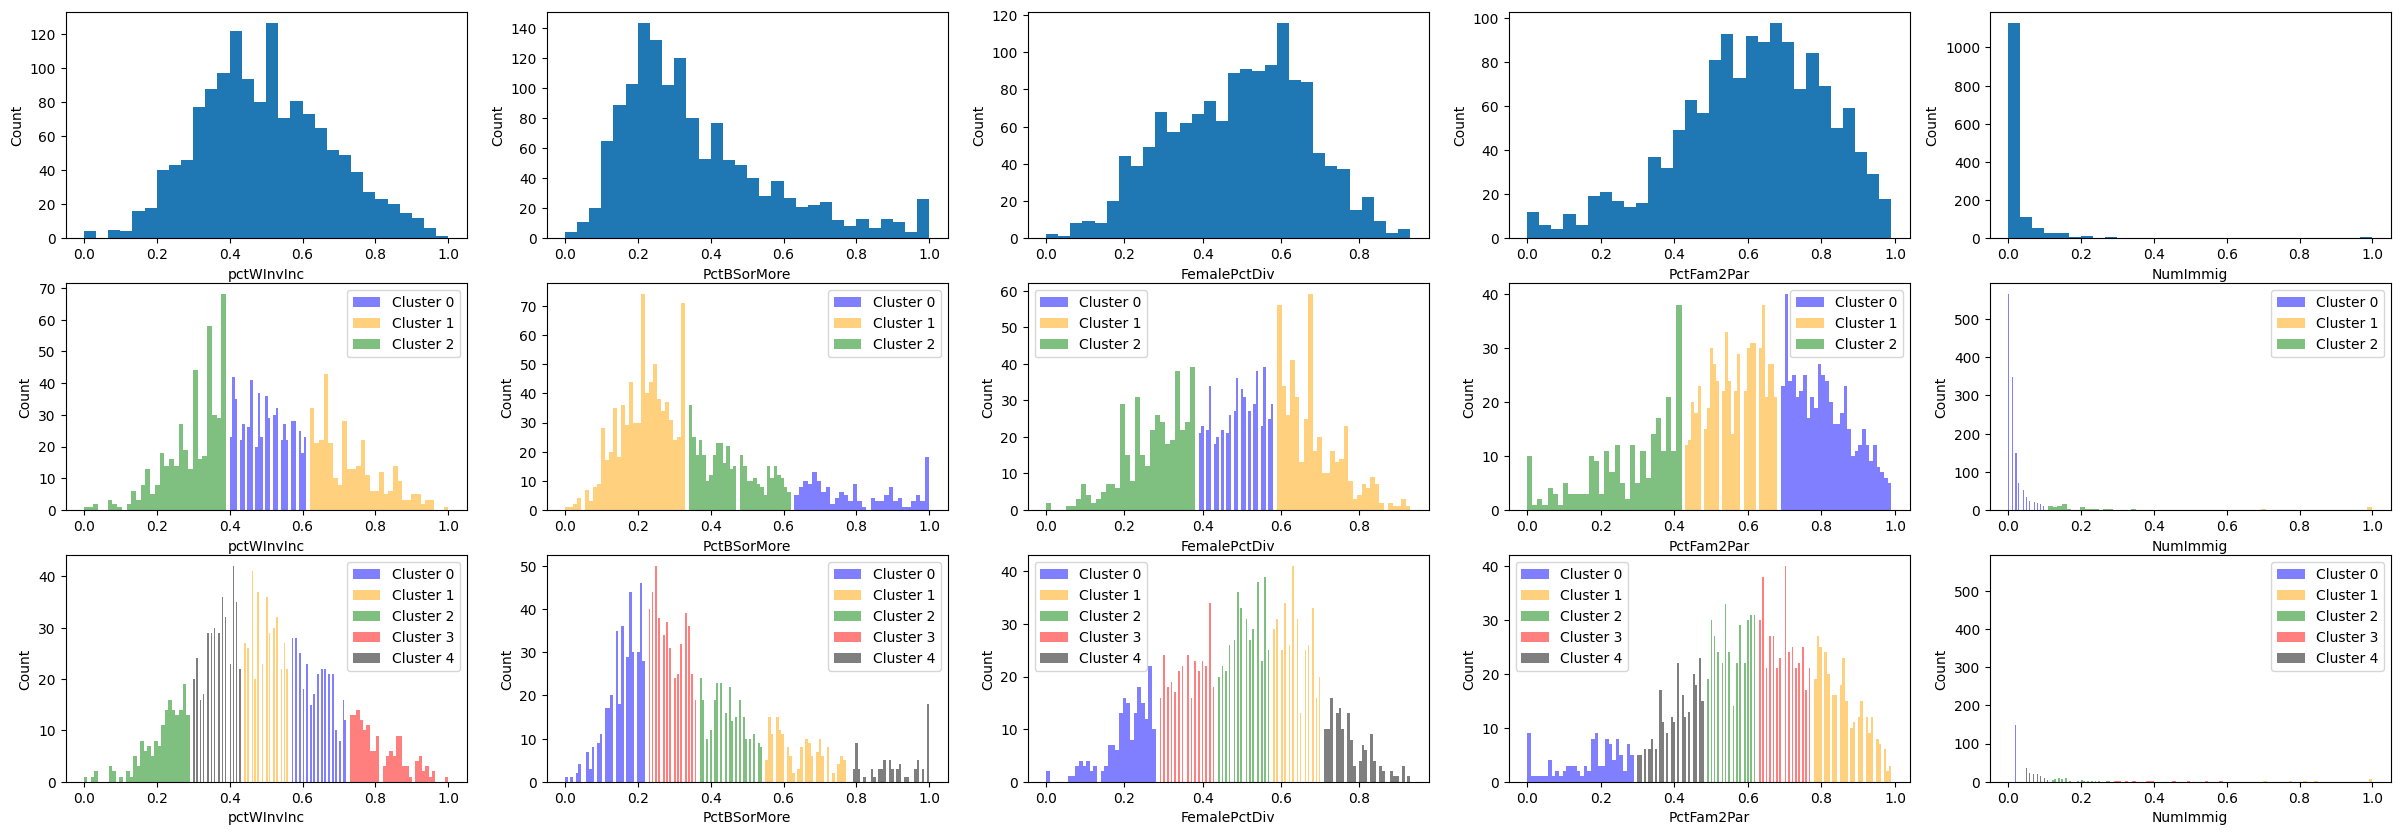

In [ ]:
num_clusters = 5

#Hide the messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def KMeans_clustering(table,feature,num_clusters):
  tempt = table.copy()
  kmeans = KMeans(n_clusters = num_clusters).fit(pd.DataFrame(tempt[feature]));
  tempt['label'] = kmeans.labels_
  return kmeans,kmeans.labels_


fig,ax = plt.subplots(nrows = 3,ncols = len(list_of_features),figsize = (30,10))

for i in range(len(list_of_features)):
  ax[0,i].hist(X_train[list_of_features[i]],bins = 30)
  ax[0,i].set_xlabel(list_of_features[i])
  ax[0,i].set_ylabel('Count')

for i in range(len(list_of_features)):
    kmeans_labels = KMeans_clustering(X_train, list_of_features[i], 3)[1]

    unique_labels = np.unique(kmeans_labels)
    colors = ['blue', 'orange', 'green']  # Define colors for each cluster label

    # Plot histograms for each feature
    for label, color in zip(unique_labels, colors):
        data_for_label = X_train[list_of_features[i]][kmeans_labels == label]
        ax[1, i].hist(data_for_label, bins=30, alpha=0.5, label=f'Cluster {label}', color=color)

    ax[1, i].set_xlabel(list_of_features[i])
    ax[1, i].set_ylabel('Count')
    ax[1, i].legend()

for i in range(len(list_of_features)):
    kmeans_labels = KMeans_clustering(X_train, list_of_features[i], 5)[1]

    unique_labels = np.unique(kmeans_labels)
    colors = ['blue', 'orange', 'green','red','black']  # Define colors for each cluster label

    # Plot histograms for each feature
    for label, color in zip(unique_labels, colors):
        data_for_label = X_train[list_of_features[i]][kmeans_labels == label]
        ax[2, i].hist(data_for_label, bins=30, alpha=0.5, label=f'Cluster {label}', color=color)

    ax[2, i].set_xlabel(list_of_features[i])
    ax[2, i].set_ylabel('Count')
    ax[2, i].legend()

plt.show()


 pctWInvInc  : 


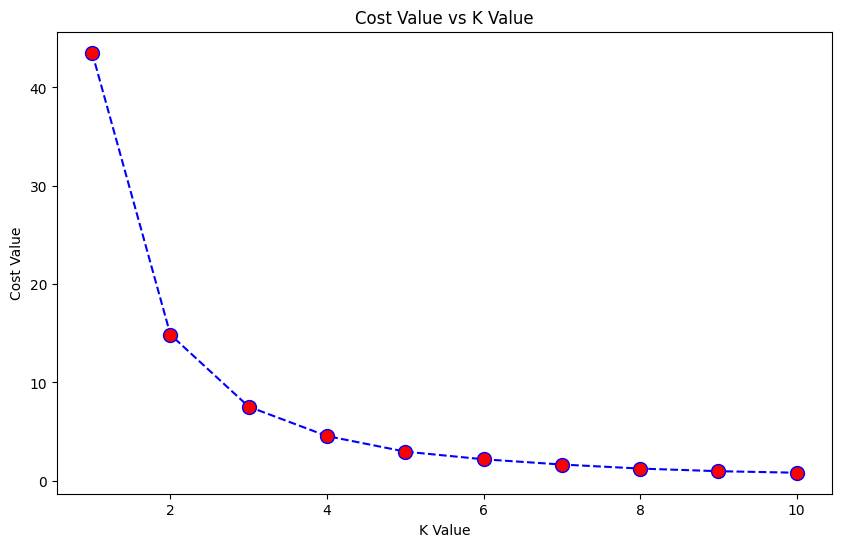


 PctBSorMore  : 


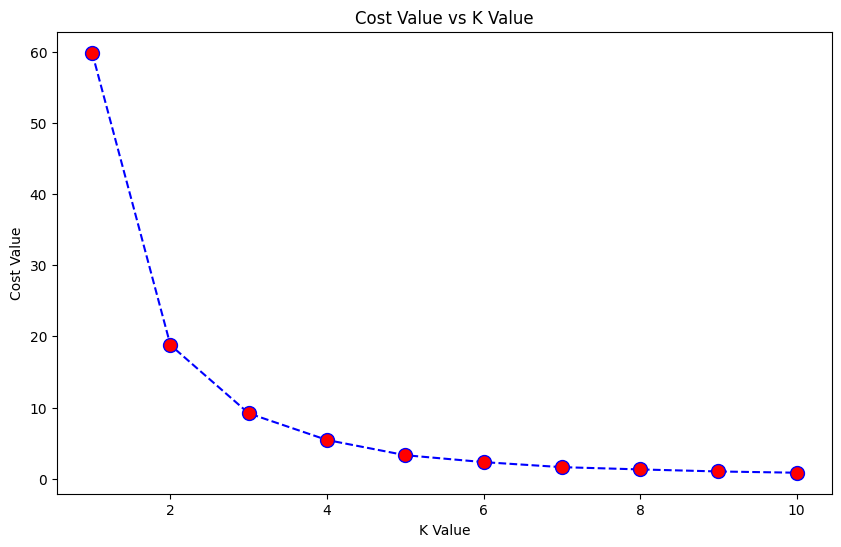


 FemalePctDiv  : 


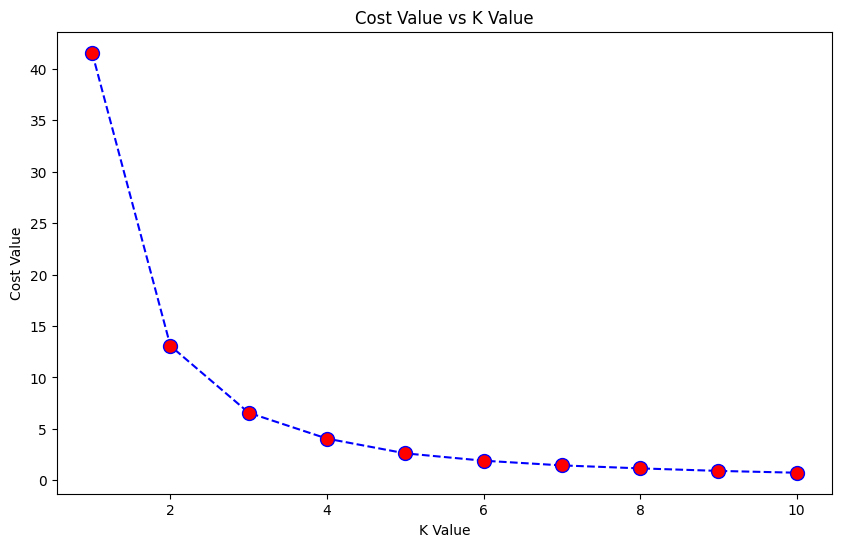


 PctFam2Par  : 


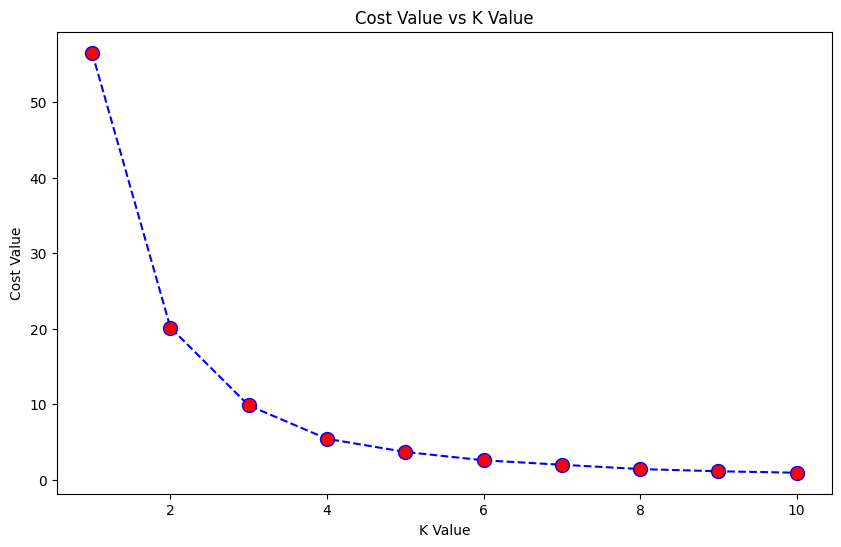


 NumImmig  : 


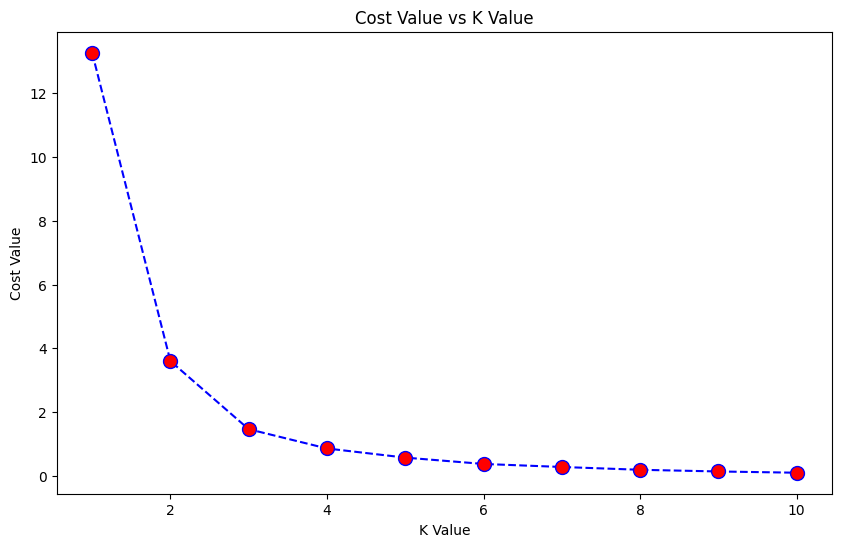

In [ ]:
for feature in list_of_features:
  cost_value = []
  print("\n", feature , " : ")
  for i in range(10):
    kmeans = KMeans_clustering(X_train,feature,i+1)[0]
    cost_value.append(kmeans.inertia_)

  plt.figure(figsize=(10,6))
  plt.plot(range(1,11),cost_value,color = 'blue',linestyle='--',marker='o',
         markerfacecolor='red',markersize=10)
  plt.title('Cost Value vs K Value')
  plt.xlabel('K Value')
  plt.ylabel('Cost Value')
  plt.show()


In [ ]:
class Fuzzify(object):
  def __init__(self,data_series,Min,Max,Mid):
    self.data = data_series
    self.feature = feature
    self.low = Min
    self.high = Max
    self.mid = Mid
    self.universe = np.arange(np.floor(self.low),np.ceil(self.high)+0.2,  0.1)
    self.trimf_low = fuzz.trimf(self.universe,[self.low,self.low,self.mid])
    self.trimf_mid = fuzz.trimf(self.universe,[self.low,self.mid,self.high+0.1])
    self.trimf_high = fuzz.trimf(self.universe,[self.mid,self.high+0.1,self.high+0.1])

  def get_universe(self):
    return self.universe

  #Assign fuzzy membership to each observation in the data series
  #and return a dataframe
  def get_membership(self):
    new_df= pd.DataFrame(self.data)
    new_df['low'] = fuzz.interp_membership(self.universe,self.trimf_low,self.data)
    new_df['mid'] = fuzz.interp_membership(self.universe,self.trimf_mid,self.data)
    new_df['high'] = fuzz.interp_membership(self.universe,self.trimf_high,self.data)
    new_df['membership'] = new_df.loc[:,['low','mid','high']].idxmax(axis = 1)
    new_df['degree'] = new_df.loc[:,['low','mid','high']].max(axis = 1)
    return new_df


In [ ]:
def get_cluster_MinMaxMid(data,feature_list,num_clusters,fuzzfied = False):
    feature_object = []
    min_max_mids = []

    for feature in feature_list:

        num_clusters = 3
        labels = KMeans_clustering(data,feature,num_clusters)[1]
        feature_tempt = data[feature].loc[:]
        tempt_df = pd.DataFrame({
            'Feature' : feature_tempt,
            'label' : labels
        })

        feature_value = []
        for i in range(num_clusters):
          feature_value.append(tempt_df[tempt_df['label'] == i]['Feature'].min())
          feature_value.append(tempt_df[tempt_df['label'] == i]['Feature'].max())

        feature_value = np.array(feature_value)

        feature_min = feature_value.min()
        feature_max = feature_value.max()
        feature_mid = np.median(feature_value)

        if fuzzfied == True:
            tempt_object = Fuzzify(feature_tempt,feature_min,feature_max,feature_mid)
            feature_object.append(tempt_object)

        min_max_mid = {
            'df' : feature_tempt,
            'min' : feature_min,
            'max' : feature_max,
            'mid' : feature_mid
        }

        min_max_mids.append(min_max_mid)

    return min_max_mids,feature_object


In [ ]:
copy_list_of_features = list_of_features


min_max_mid = get_cluster_MinMaxMid(X_train,[copy_list_of_features[0]],3)
min_max_dict = min_max_mid[0][0]
feature1_object = Fuzzify(min_max_dict['df'], min_max_dict['min'], min_max_dict['max'], min_max_dict['mid'])
fuzzified_feature1 = feature1_object.get_membership()

fuzzified_feature1.head()

,pctWInvInc,low,mid,high,membership,degree
557,0.45,0.126214,0.873786,0.000000,mid,0.873786
694,0.29,0.436893,0.563107,0.000000,mid,0.563107
1718,0.30,0.417476,0.582524,0.000000,mid,0.582524
1342,0.67,0.000000,0.735043,0.264957,mid,0.735043
1159,0.36,0.300971,0.699029,0.000000,mid,0.699029


In [ ]:
#Calculate X membership function
feature_min_max_mid = get_cluster_MinMaxMid(X_train,copy_list_of_features,3,fuzzfied = True)

In [ ]:
#Calculate Y membership function
target_min_max_mid = get_cluster_MinMaxMid(y_train,['ViolentCrimesPerPop'],3,fuzzfied = True)

In [ ]:
X_train[copy_list_of_features]

,pctWInvInc,PctBSorMore,FemalePctDiv,PctFam2Par,NumImmig
557,0.45,0.36,0.63,0.56,0.08
694,0.29,0.17,0.63,0.52,0.00
1718,0.30,0.23,0.65,0.26,0.00
1342,0.67,0.27,0.34,0.69,0.01
1159,0.36,0.43,0.78,0.18,0.49
...,...,...,...,...,...
1130,0.58,0.42,0.50,0.75,0.01
1294,0.52,0.18,0.38,0.68,0.04
860,0.65,0.32,0.37,0.71,0.01
1459,0.53,0.26,0.60,0.58,0.08


In [ ]:
train_data = X_train[copy_list_of_features]
train_data = train_data.join(y_train)

In [ ]:
feature_object = feature_min_max_mid[1] + target_min_max_mid[1]
def get_rule(train_data, X_train, y_train, feature_object):
  rule_df = train_data.copy()
  rule_df['degree'] = np.ones(X_train.shape[0])
  for col in train_data.columns[:]:
    idx = train_data.columns.get_loc(col)
    feature_membership = feature_object[idx].get_membership()
    rule_df[col] = feature_membership['membership']
    rule_df['degree'] *= feature_membership['degree']
  final_rule = rule_df
  final_rule['ViolentCrimesPerPop Value'] = y_train.iloc[:]
  final_rule = final_rule.groupby(list(rule_df.columns[:-3])).max()
  final_rule = final_rule.reset_index()
  col_to_move = final_rule.pop('degree')
  final_rule['degree'] = col_to_move
  return final_rule

In [ ]:
rules = get_rule(train_data,X_train,y_train, feature_object)
rules.sort_values(by = 'degree',ascending=False,inplace = True)
rules

,pctWInvInc,PctBSorMore,FemalePctDiv,PctFam2Par,NumImmig,ViolentCrimesPerPop,ViolentCrimesPerPop Value,degree
49,mid,mid,mid,mid,low,mid,1.00,0.617350
35,mid,low,mid,mid,low,mid,1.00,0.597315
18,low,mid,mid,low,low,mid,1.00,0.494973
48,mid,mid,mid,mid,high,mid,1.00,0.470402
10,low,low,high,low,low,mid,1.00,0.439941
42,mid,mid,low,high,low,mid,0.26,0.419947
16,low,low,mid,mid,mid,mid,0.62,0.417150
43,mid,mid,low,mid,low,mid,0.22,0.409398
15,low,low,mid,mid,low,mid,0.93,0.387697
8,high,mid,mid,mid,low,mid,0.36,0.385173


# **Model Building**

In [ ]:
#Define input and output
antecedent = {}
for feature in copy_list_of_features:
   antecedent[feature] = ctrl.Antecedent(np.arange(0,1+0.1,0.1),feature)

column_name = y_train.columns[0]

consequent = ctrl.Consequent(np.arange(0,1+0.1,0.1), column_name)

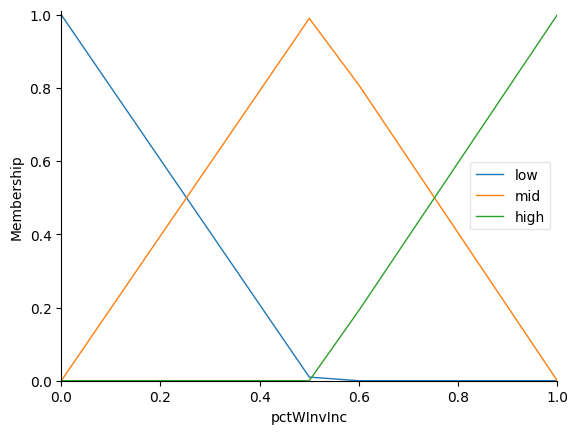

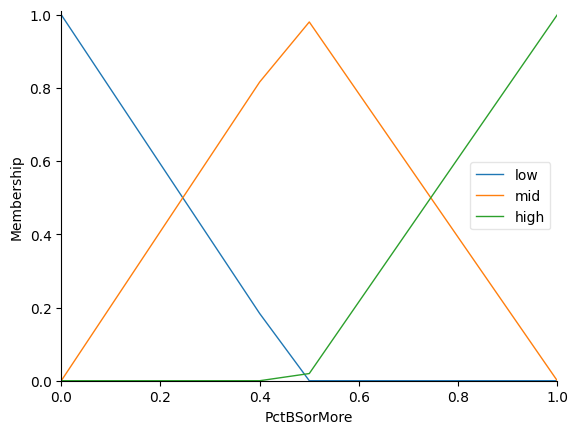

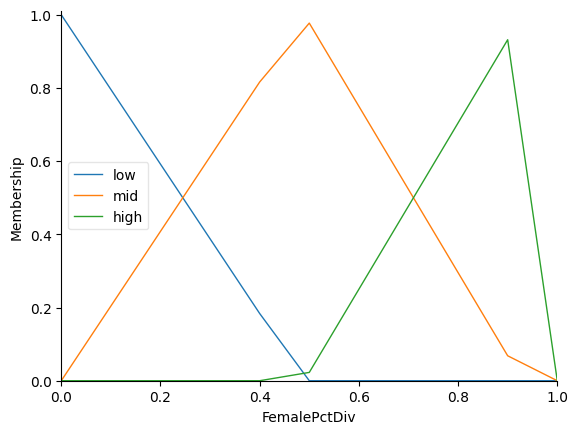

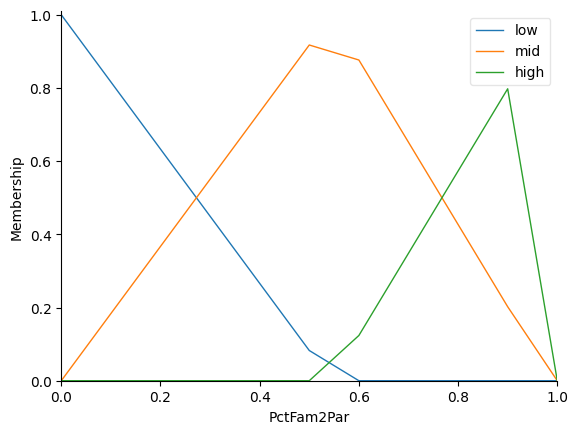

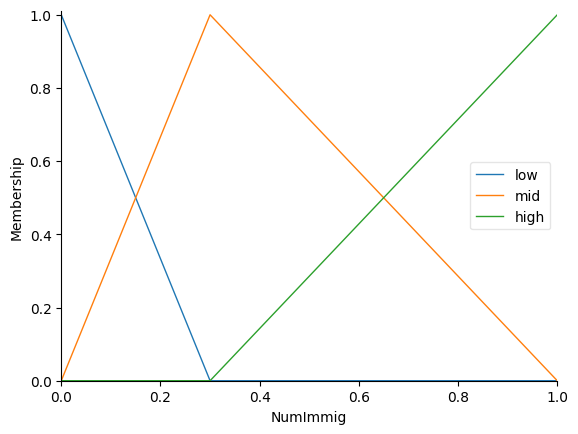

In [ ]:
#Define membership function
for feature in antecedent.keys():

  min_max_mid = get_cluster_MinMaxMid(X_train,[feature],3)[0]

  low = min_max_mid[0]['min']
  high = min_max_mid[0]['max']
  mid = min_max_mid[0]['mid']

  antecedent[feature]['low'] = fuzz.trimf(antecedent[feature].universe,[low,low,mid])
  antecedent[feature]['mid'] = fuzz.trimf(antecedent[feature].universe,[low,mid,high])
  antecedent[feature]['high'] = fuzz.trimf(antecedent[feature].universe,[mid,high,high])
  antecedent[feature].view()

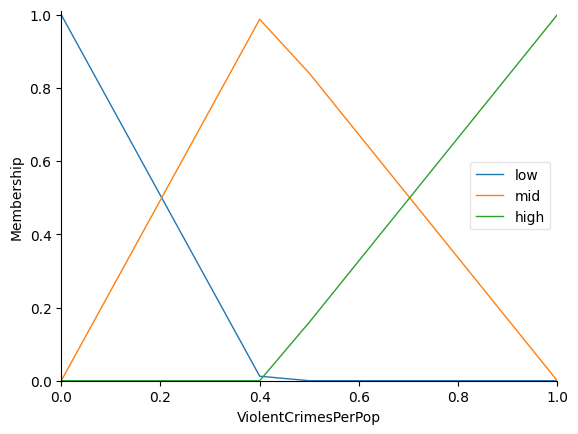

In [ ]:
min_max_mid = get_cluster_MinMaxMid(y_train,[y_train.columns[0]],3)[0]

low = min_max_mid[0]['min']
high = min_max_mid[0]['max']
mid = min_max_mid[0]['mid']

consequent['low'] = fuzz.trimf(consequent.universe,[low,low,mid])
consequent['mid'] = fuzz.trimf(consequent.universe,[low,mid,high])
consequent['high'] = fuzz.trimf(consequent.universe,[mid,high,high])
consequent.view()

In [ ]:
# Extract Unique Rules
def extract_rule_list(rule):

  # Generate Fuzzy Control Rules
  rules_list = []

  # Iterate over each row in the rules DataFrame
  for i in range(len(rules)):
      row = rules.iloc[i]
      antecedent_rules = []

      # Iterate over the antecedent columns (excluding the last two columns)
      for antecedent_name in antecedent.keys():
          membership = row[antecedent_name]
          antecedent_fuzzy_set = antecedent[antecedent_name]
          antecedent_membership = antecedent_fuzzy_set[membership]
          antecedent_rules.append(antecedent_membership)

      consequent_name = row['ViolentCrimesPerPop']
      consequent_fuzzy_set = consequent[consequent_name]

      #Create the fuzzy control rule and append it to rules_list
      rule = None
      for j in range(len(copy_list_of_features)):
        if rule == None:
          rule = antecedent_rules[j]
        else:
          rule &= antecedent_rules[j]

      rule = ctrl.Rule(rule,consequent_fuzzy_set, label=f"Rule {i}")
      rules_list.append(rule)

  return rules_list

In [ ]:
rules_list = extract_rule_list(rules)
rules_list

[IF (((pctWInvInc[mid] AND PctBSorMore[mid]) AND FemalePctDiv[mid]) AND PctFam2Par[mid]) AND NumImmig[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((pctWInvInc[mid] AND PctBSorMore[low]) AND FemalePctDiv[mid]) AND PctFam2Par[mid]) AND NumImmig[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((pctWInvInc[low] AND PctBSorMore[mid]) AND FemalePctDiv[mid]) AND PctFam2Par[low]) AND NumImmig[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((pctWInvInc[mid] AND PctBSorMore[mid]) AND FemalePctDiv[mid]) AND PctFam2Par[mid]) AND NumImmig[high] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((pctWInvInc[low] AND PctBSorMore[low]) AND FemalePctDiv[high]) AND PctFam2Par[low]) AND NumImmig[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	O

In [ ]:
def predict_with_fuzzy_system(X, y, list_of_features, rules_list):

    consequent_ctrl = ctrl.ControlSystem(rules_list)
    pred = ctrl.ControlSystemSimulation(consequent_ctrl)

    actual_values = []
    predicted_values = []

    # Iterate over the training data
    for i in range(len(X)):
        input_data = X.iloc[i]

        # Set input values for each feature in the fuzzy system
        for feature in list_of_features:
            pred.input[feature] = input_data[feature]

        # Compute the output of the fuzzy system
        pred.compute()

        predicted_value = pred.output['ViolentCrimesPerPop']
        predicted_values.append(predicted_value)

        # Get the actual value of the target variable
        actual_value = y.iloc[i]['ViolentCrimesPerPop']
        actual_values.append(actual_value)

    # Print output
    print("\nOutput:")
    print("Predicted Violent Crimes Per Pop:", pred.output['ViolentCrimesPerPop'])

    # Show the output membership function
    consequent.view(sim=pred)

    return actual_values, predicted_values

Prediction using training set:

Output:
Predicted Violent Crimes Per Pop: 0.4524429477980823


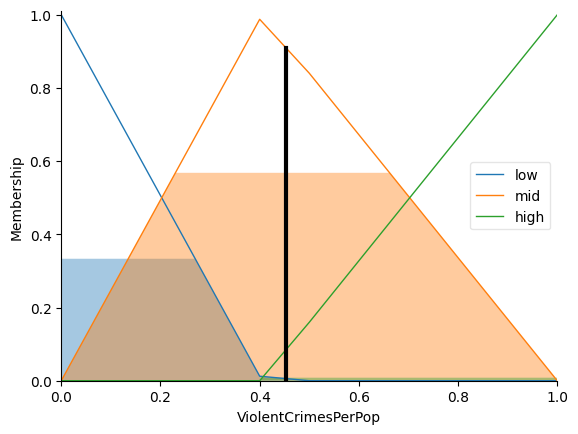

In [ ]:
print("Prediction using training set:")
actual_values_train, predicted_values_train = predict_with_fuzzy_system(X_train, y_train, list_of_features, rules_list)

In [ ]:
def calculate_performance(actual_values, predicted_values):

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    print("Mean Squared Error:", mse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    print("Mean Absolute Error:", mae)

    return mse, mae

In [ ]:
print("Performance calculated for training set:")
mse_train, mae_train = calculate_performance(actual_values_train, predicted_values_train)

Performance calculated for training set:
Mean Squared Error: 0.09771974068731215
Mean Absolute Error: 0.28767733949086977


# **Model Tuning**


In [ ]:
import time

Settings  1  :  [50, 0.005, 5, False, True]
-------------------------------------------
Variance is :  6.411186866296001e-05
Average fitness is:  -0.03805784603514108

Result - 
Top feature in binary form :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
List of top features :  ['PctOccupMgmtProf', 'PctImmigRec8', 'RentHighQ', 'MedOwnCostPctIncNoMtg']
Best score :  -0.03774364192151532

Output:
Predicted Violent Crimes Per Pop: 0.46281638666573666

Performance calculated for validation set : 
Mean Squared Error: 0.09785729697140554
Mean Absolute Error: 0.28784357606104793

Running time:  53.83 seconds



Settings  2  :  [50, 0.05, 5, False, True]
-------------------------------------------
Variance is :  5.595362799320859e-05
Average

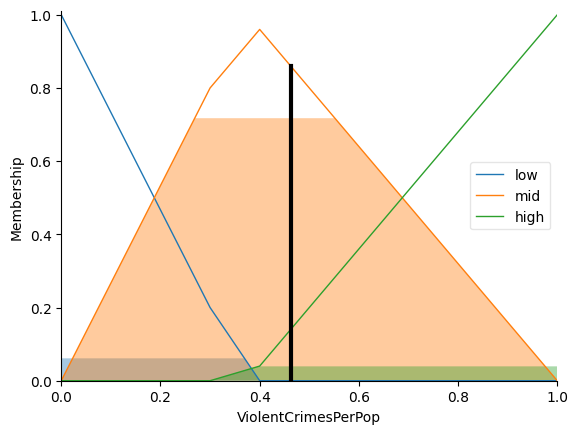

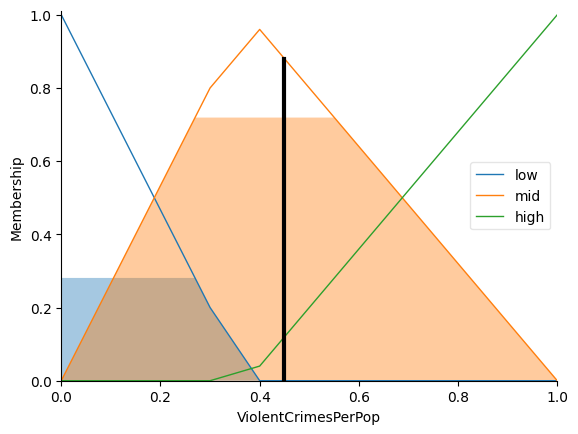

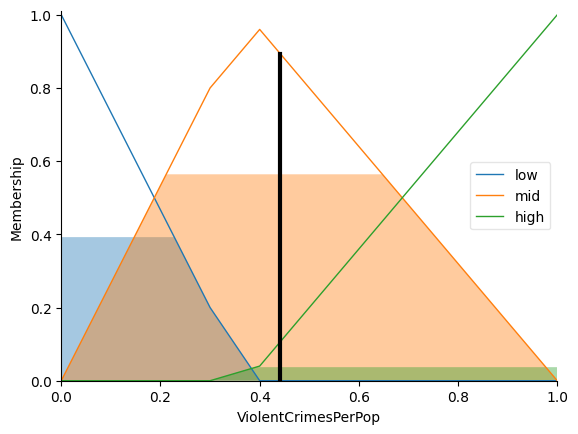

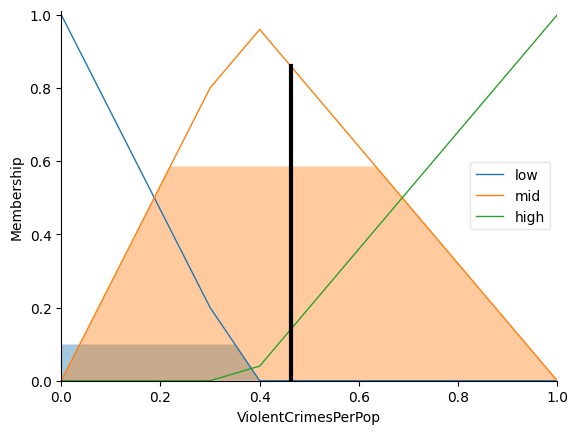

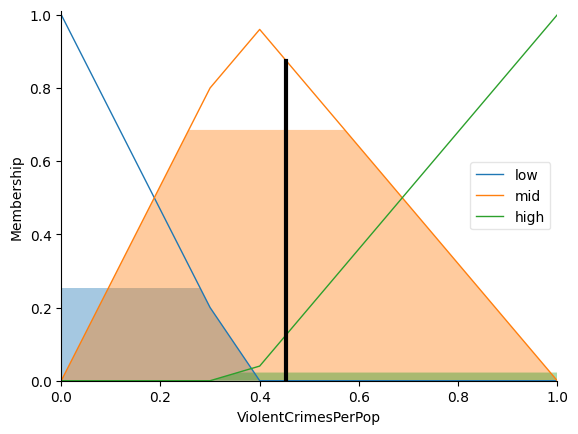

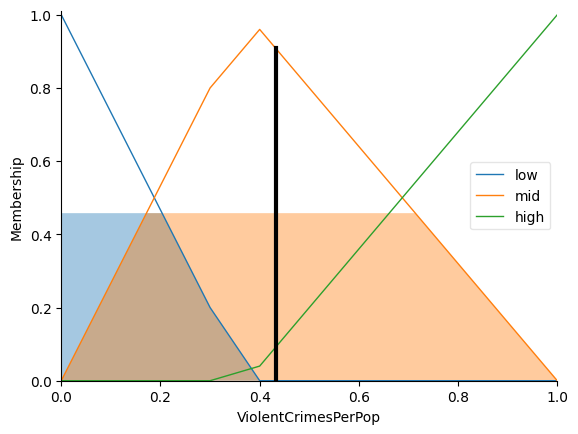

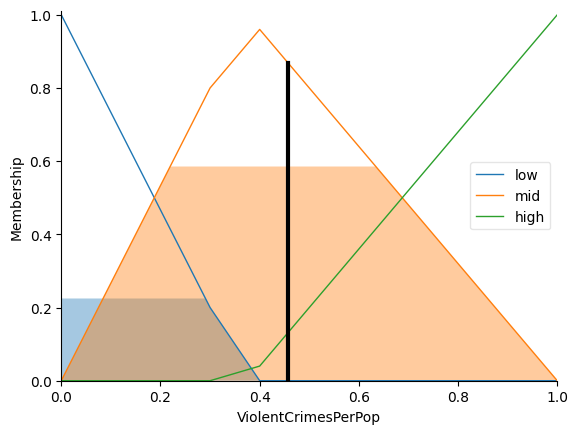

In [ ]:
#[population_size,top_level,num_top_feature,genetic_algo,correlation]

def get_actual_prediction(X,y,copy_list_of_features,rules_list):

  consequent_ctrl = ctrl.ControlSystem(rules_list)
  pred = ctrl.ControlSystemSimulation(consequent_ctrl)

  actual_values = []
  predicted_values = []

  # Iterate over the training data
  for i in range(len(X)):
      input_data = X.iloc[i]

      # Set input values for each feature in the fuzzy system
      for feature in copy_list_of_features:
          pred.input[feature] = input_data[feature]

      # Compute the output of the fuzzy system
      pred.compute()

      predicted_value = pred.output['ViolentCrimesPerPop']
      predicted_values.append(predicted_value)

      # Get the actual value of the target variable
      actual_value = y.iloc[i]['ViolentCrimesPerPop']
      actual_values.append(actual_value)

  # Print output
  print("\nOutput:")
  print("Predicted Violent Crimes Per Pop:", pred.output['ViolentCrimesPerPop'])

  # Show the output membership function
  consequent.view(sim=pred)


  return actual_values,predicted_values


###################################################################################
def extract_rule_list_test(rules,antecedent,copy_list_of_features):
  rules_list = []

  # Iterate over each row in the rules DataFrame
  for i in range(len(rules)):
      row = rules.iloc[i]
      antecedent_rules = []

      # Iterate over the antecedent columns (excluding the last two columns)
      for antecedent_name in antecedent.keys():
          membership = row[antecedent_name]
          antecedent_fuzzy_set = antecedent[antecedent_name]
          antecedent_membership = antecedent_fuzzy_set[membership]
          antecedent_rules.append(antecedent_membership)

      consequent_name = row['ViolentCrimesPerPop']
      consequent_fuzzy_set = consequent[consequent_name]

      #Create the fuzzy control rule and append it to rules_list
      rule = None
      for j in range(len(copy_list_of_features)):
        if rule == None:
          rule = antecedent_rules[j]
        else:
          rule &= antecedent_rules[j]

      rule = ctrl.Rule(rule,consequent_fuzzy_set, label=f"Rule {i}")
      rules_list.append(rule)
  return rules_list

##################################################################################
def model_tunning(X,y,settings):
  df = pd.concat([X,y],axis = 1)
  if settings[3] == True:
    filter_low_correlation_features_with_target(df,0.3,y.columns)
    filter_high_correlation_features_with_target(df,y.columns,0.85)

  top_features, best_score = genetic_algo(df,X, y,settings[0],settings[1],settings[2])

  #printing top features selected through genetic algorithm
  i = 0
  list_of_features= []
  for i in range(len(top_features)):
    if(top_features[i]==1):
      list_of_features.append(df[df.columns].columns[i])

  print("\nResult - ")
  print("Top feature in binary form : ", top_features)
  print("List of top features : ",list_of_features)
  print("Best score : ", best_score)

  #Define rules
  feature_object = []
  copy_list_of_features = list_of_features

  feature_min_max_mid = []
  target_min_max_mid = []

  feature_min_max_mid = get_cluster_MinMaxMid(X,copy_list_of_features,3,fuzzfied = True)[1]
  target_min_max_mid = get_cluster_MinMaxMid(y,['ViolentCrimesPerPop'],3,fuzzfied = True)[1]
  feature_object = feature_min_max_mid + target_min_max_mid

  train_data = X[copy_list_of_features]
  train_data = train_data.join(y)

  #Define rule,antecedent and consequent
  antecedent = {}
  for feature in copy_list_of_features:
    antecedent[feature] = ctrl.Antecedent(np.arange(0,1+0.1,0.1),feature)

  column_name = y.columns[0]

  consequent = ctrl.Consequent(np.arange(0,1+0.1,0.1), column_name)

  for feature in antecedent.keys():
    min_max_mid = get_cluster_MinMaxMid(X,[feature],3)[0]

    low = min_max_mid[0]['min']
    high = min_max_mid[0]['max']
    mid = min_max_mid[0]['mid']

    antecedent[feature]['low'] = fuzz.trimf(antecedent[feature].universe,[low,low,mid])
    antecedent[feature]['mid'] = fuzz.trimf(antecedent[feature].universe,[low,mid,high])
    antecedent[feature]['high'] = fuzz.trimf(antecedent[feature].universe,[mid,high,high])

  min_max_mid = {'min': 0, 'max': 0, 'mid': 0}

  min_max_mid = get_cluster_MinMaxMid(y,[y.columns[0]],3)[0]

  low = min_max_mid[0]['min']
  high = min_max_mid[0]['max']
  mid = min_max_mid[0]['mid']

  consequent['low'] = fuzz.trimf(consequent.universe,[low,low,mid])
  consequent['mid'] = fuzz.trimf(consequent.universe,[low,mid,high])
  consequent['high'] = fuzz.trimf(consequent.universe,[mid,high,high])

  rules = get_rule(train_data, X, y, feature_object) ######## add 2 more parameter
  rules.sort_values(by = 'degree',ascending=False,inplace = True)
  rules_list = extract_rule_list_test(rules,antecedent,copy_list_of_features)

  #Prediction on validation set
  actual_values, predicted_values = get_actual_prediction(X, y, copy_list_of_features, rules_list)

  print("\nPerformance calculated for validation set : ")
  mse, mae = calculate_performance(actual_values, predicted_values)
  return antecedent, consequent, rules_list, mse

#################################################################################

settings = [
            [50,0.005,5,False],
            [50,0.05,5,False],
            [50,0.005,10,False],

            [100,0.05,5,True],
            [50,0.005,5,True],
            [50,0.005,10,True],
            [50,0.05,15,True]]

mse = []

for i in range(len(settings)):
  start_time = time.time()

  print("Settings ",i+1," : ",settings[i])
  print("-------------------------------------------")
  _, _, _, tempt = model_tunning(X_val,y_val,settings[i])
  mse.append(tempt)

  end_time = time.time()
  diff_time = end_time - start_time
  print("\nRunning time: ", round(diff_time,2), "seconds")

  print("\n\n")

best_setting_index = np.argmin(mse)
best_setting = settings[best_setting_index]
print("Best settings : ", best_setting)
print("MSE : ", mse[best_setting_index])

# **Model Testing**

Testing with the best setting
Features with low correlation with target that has been dropped :  []
Feature with high correlation with target that has been dropped :  {'PersPerFam', 'PctForeignBorn', 'PctWorkMomYoungKids', 'PctImmigRecent', 'PctTeen2Par', 'agePct16t24', 'medIncome', 'whitePerCap', 'PctRecImmig8', 'PctLargHouseOccup', 'MalePctDivorce', 'OwnOccMedVal', 'MedRent', 'PctYoungKids2Par', 'PctFam2Par', 'PctBSorMore', 'PctNotSpeakEnglWell', 'PctOccupMgmtProf', 'PersPerOccupHous', 'perCapInc', 'agePct12t21', 'population', 'PctEmploy', 'PctImmigRec8', 'PctRecImmig5', 'RentMedian', 'householdsize', 'NumInShelters', 'OwnOccLowQuart', 'PctImmigRec5', 'RentHighQ', 'PctRecentImmig', 'PctRecImmig10', 'HousVacant', 'NumUnderPov', 'PctLess9thGrade', 'TotalPctDiv', 'PctHousOwnOcc', 'PctLargHouseFam', 'agePct65up', 'racePctHisp', 'numbUrban', 'OwnOccHiQuart'}
Variance is :  1.54437760030715e-05
Average fitness is:  -0.02926749260788928

Result - 
Top feature in binary form :  [0, 0, 0, 1, 

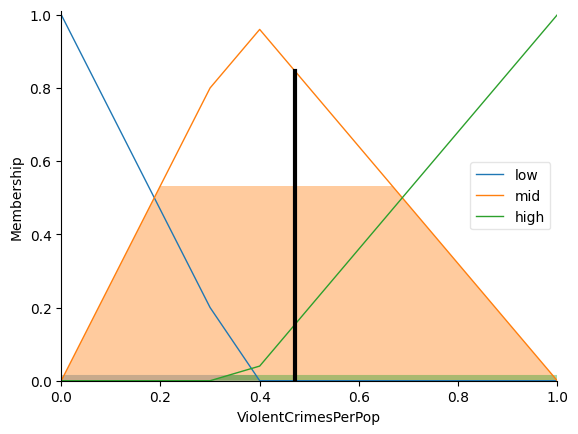

In [ ]:
# Use the best setting for testing and display output defuzzification
print("Testing with the best setting")
antecedent, consequent, rules_list, mse = model_tunning(X_test, y_test, best_setting)

Membership Functions:


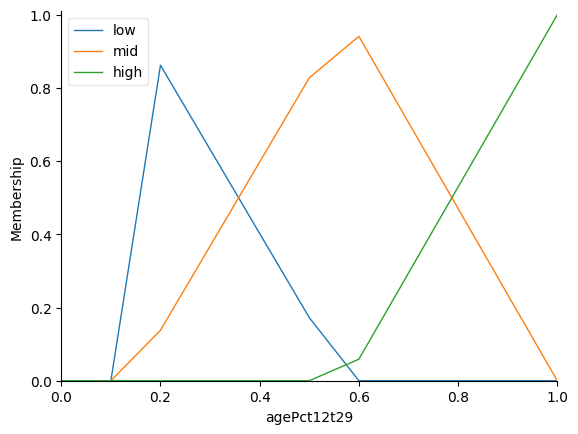

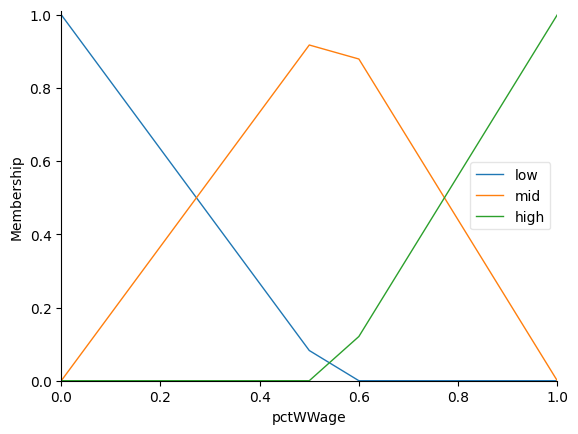

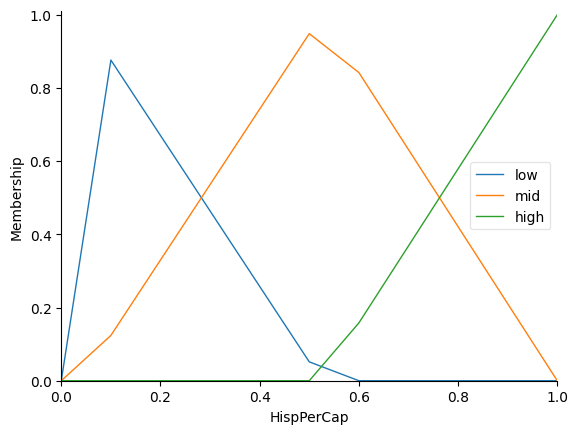

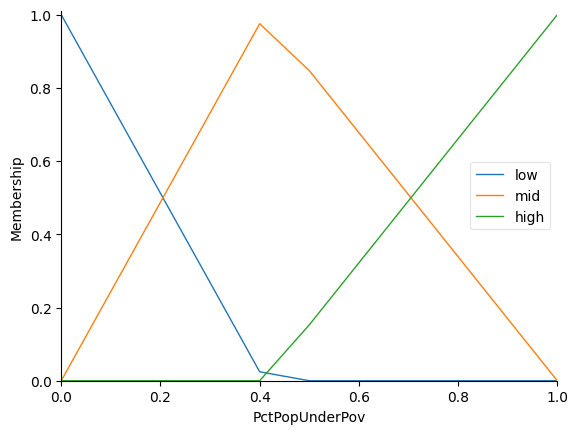

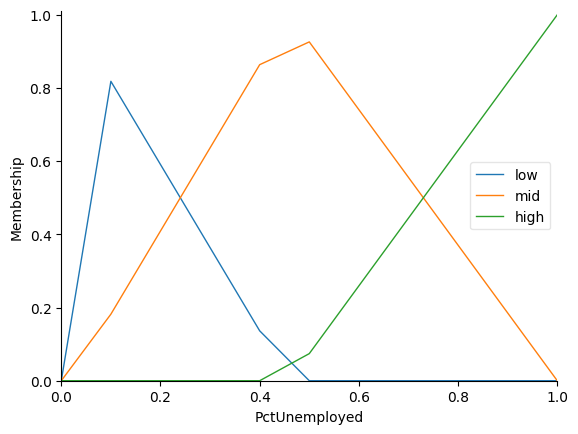

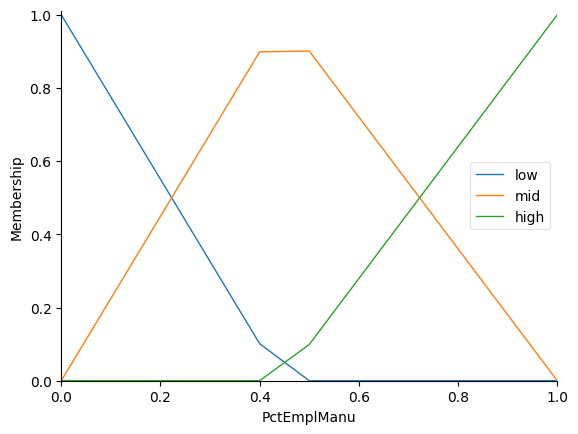

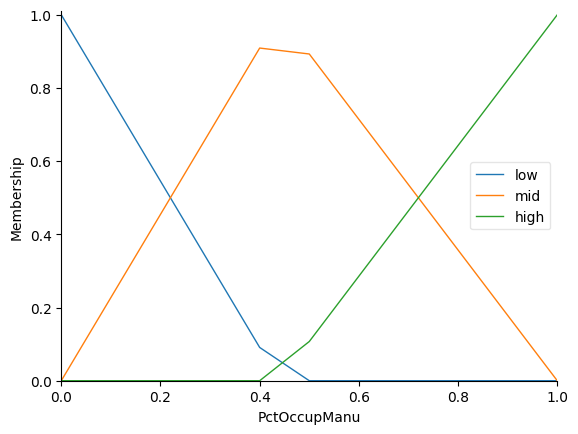

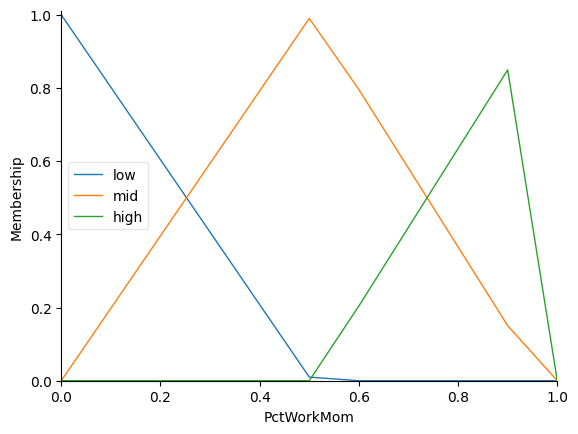

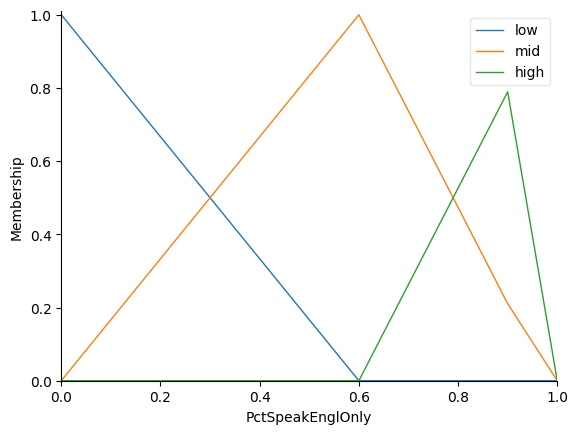

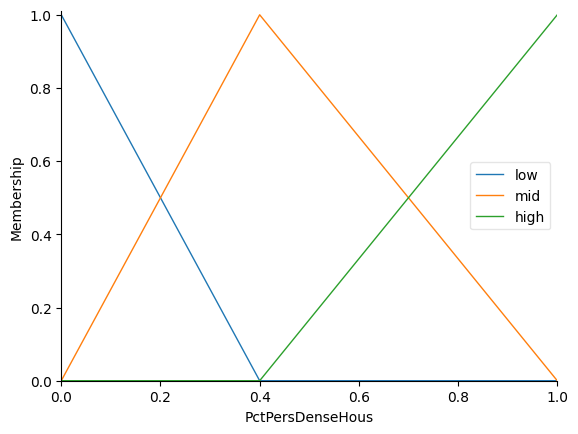

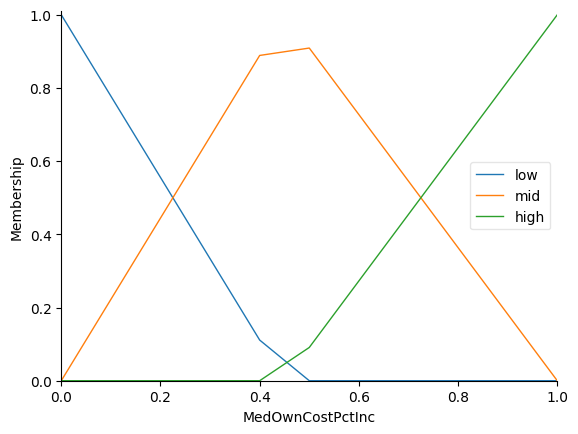

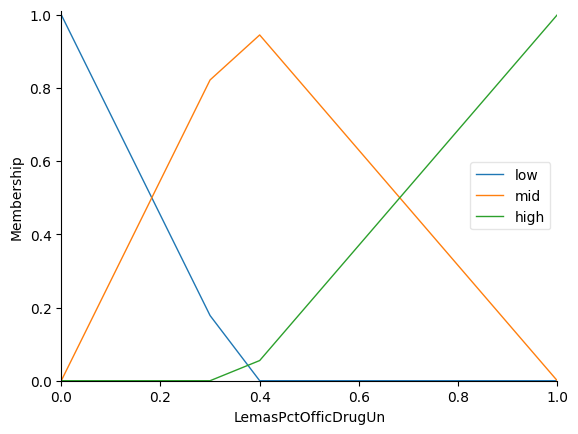

In [ ]:
# Display the membership functions
print("Membership Functions:")
for feature in antecedent.keys():
    antecedent[feature].view()

In [ ]:
# Display the rules list
print("Rules List:")
for rule in rules_list:
    print(rule)

Rules List:
IF ((((((((((agePct12t29[mid] AND pctWWage[mid]) AND HispPerCap[low]) AND PctPopUnderPov[mid]) AND PctUnemployed[mid]) AND PctEmplManu[mid]) AND PctOccupManu[mid]) AND PctWorkMom[mid]) AND PctSpeakEnglOnly[mid]) AND PctPersDenseHous[mid]) AND MedOwnCostPctInc[mid]) AND LemasPctOfficDrugUn[low] THEN ViolentCrimesPerPop[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
IF ((((((((((agePct12t29[mid] AND pctWWage[mid]) AND HispPerCap[mid]) AND PctPopUnderPov[mid]) AND PctUnemployed[mid]) AND PctEmplManu[mid]) AND PctOccupManu[mid]) AND PctWorkMom[mid]) AND PctSpeakEnglOnly[mid]) AND PctPersDenseHous[low]) AND MedOwnCostPctInc[mid]) AND LemasPctOfficDrugUn[low] THEN ViolentCrimesPerPop[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
IF ((((((((((agePct12t29[mid] AND pctWWage[mid]) AND HispPerCap[mid]) AND PctPopUnderPov[mid]) AND PctUnemployed[mid]) AND PctEmplManu[low]) AND PctOccupManu[mid]) AND PctWorkMom[mid]) AND PctSpeakEnglOnly[